# Tests with the Kalman Filter

In [ ]:
import math
import datetime

import numpy as np
import pandas as pd

import simdkalman
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The Data

Load the preprocessed data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd '/content/gdrive/My Drive/Colab Notebooks/aiforsea'

/content/gdrive/My Drive/Colab Notebooks/aiforsea


In [7]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Collect info for each location

In [8]:
locations = df['geohash6'].unique()
print(len(locations), locations)

1329 ['qp02yc' 'qp02z1' 'qp02z3' ... 'qp0djw' 'qp0djy' 'qp0dnn']


## The Kalman Filter

In [ ]:
train_start = pd.to_datetime('1900-01-18 00:00:00')
train_stepdelta = datetime.timedelta(days=1, hours=1, minutes=15)
train_horizon = datetime.timedelta(days=14)
location = 'qp09d2'

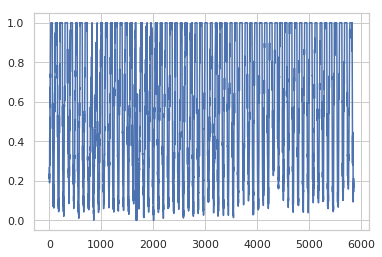

In [77]:
df_loc = df[(df['geohash6'] == location)].reset_index().drop('index', axis=1)
df_loc = df_loc.rename(columns={'demand' : 'y'}).drop(['geohash6', 'in_raw',
                                                     'weekday', 'hour', 'minutes',
                                                     'latitude', 'longitude'], axis=1)
plt.plot(df_loc['y'])

In [ ]:
kalman0_mse_sum = 0
kalman1_mse_sum = 0

In [79]:
%%time
for i in range(20):
  # collect data from location 
  start_date = train_start + i*train_stepdelta
  end_date   = train_start + i*train_stepdelta + train_horizon
  print(start_date, end_date)
  
  df_loc = df[(start_date <= pd.to_datetime(df['ds'])) &
              (pd.to_datetime(df['ds']) <= train_start + i*train_stepdelta + train_horizon) &
              (df['geohash6'] == location)].reset_index().drop('index', axis=1)
  df_loc = df_loc.rename(columns={'demand' : 'y'}).drop(['geohash6', 'in_raw',
                                                       'weekday', 'hour', 'minutes',
                                                       'latitude', 'longitude'], axis=1)
  
  # train-test split
  df_train = df_loc.iloc[:-5]
  df_test  = df_loc.iloc[-5:]
  
  kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 0.5)
  
  kalman_predictions = kf.predict(df_train['y'].values, 5)
  
  kalman0_pred = kalman_predictions.states.mean[:,0]
  kalman1_pred = kalman_predictions.states.mean[:,1]
  
  kalman0_pred = np.clip(kalman0_pred, a_min=0.0, a_max=1.0)
  kalman1_pred = np.clip(kalman1_pred, a_min=0.0, a_max=1.0)
  
  kalman0_mse_sum += mean_squared_error(kalman0_pred, df_test.y)
  kalman1_mse_sum += mean_squared_error(kalman1_pred, df_test.y)
  
  print("kalman0_rmse            ", math.sqrt(kalman0_mse_sum           /(i+1)))
  print("kalman1_rmse            ", math.sqrt(kalman1_mse_sum           /(i+1)))
  print("done", i)

1900-01-18 00:00:00 1900-02-01 00:00:00
kalman0_rmse             0.16279895710701706
kalman1_rmse             0.2867848662148205
done 0
1900-01-19 01:15:00 1900-02-02 01:15:00
kalman0_rmse             0.12225157535374899
kalman1_rmse             0.27175298924755803
done 1
1900-01-20 02:30:00 1900-02-03 02:30:00
kalman0_rmse             0.10270915336589533
kalman1_rmse             0.2888441468455182
done 2
1900-01-21 03:45:00 1900-02-04 03:45:00
kalman0_rmse             0.1372366511844568
kalman1_rmse             0.468456853276327
done 3
1900-01-22 05:00:00 1900-02-05 05:00:00
kalman0_rmse             0.12674376112061847
kalman1_rmse             0.5849692458002957
done 4
1900-01-23 06:15:00 1900-02-06 06:15:00
kalman0_rmse             0.11579509027454302
kalman1_rmse             0.6657780379853525
done 5
1900-01-24 07:30:00 1900-02-07 07:30:00
kalman0_rmse             0.10720542203114902
kalman1_rmse             0.7213590094223356
done 6
1900-01-25 08:45:00 1900-02-08 08:45:00
kalman0_r